# Submission of Team *IIQ@QIC*

We are the team "IIQ@QIC" from the [Johannes Kepler University Linz (JKU)](http://iic.jku.at/eda/research/quantum/). 
This jupyter notebook describes the essential parts of our submitted Python script, i.e., the code building the circuit without the parts that submit the circuit to IBMQ and create the answer file. 
We would like to thank the people at IBM and Anglehack for organizing the challenge, which was great fun and deepened our understanding of quantum computing.


For the problem at hand, we organized the 32 available qubits in the following layout `[start:end)`:
```
  0:14 input qubits representing the color of each node
 14:17 "tree" ancillae
 15:22 "mct ancillae"
 22:31 interim targets
 31:32 final target (a single qubit)
(18:29 ancillae for the diffusion phase)
```
## Python Preparation

The following snippet shows the preparations required to run the code.

First, the necessary packages are imported from Qiskit and the standard library.

In [1]:
from qiskit import execute, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.qasm import pi
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

from typing import Tuple, Sequence

In order to have meaningful type hints and to avoid magic numbers, the following constants are defined.

In [2]:
# Type names
Node = int
Qubit = int
# Constants to distinguish kombini brands
A = 10
B = 11
C = 12
D = 13
AC = 14

## Building Blocks of our Approach

The methods provided by Qiskit have to work in the general case, which wasn't what we strictly needed in our approach.
Therefore we optimized these methods to suit our needs while incurring less costs.

In the following, we have implemented the [CCX](https://github.com/Qiskit/qiskit-terra/blob/e0e6da5b293807fa1a264e1b29b33fb6188d010e/qiskit/extensions/standard/ccx.py#L85) and [MCT](https://github.com/Qiskit/qiskit-aqua/blob/b9bfa31d01d2cb87475aae077ee52fe2c12775e9/qiskit/aqua/circuits/gates/multi_control_toffoli_gate.py#L32) operations, that ensure the correct phase, based on the code available in Qiskit.

In [3]:
def ccx_opt(qc: QuantumCircuit, a: Qubit, b: Qubit, target: Qubit) -> None:
    qc.cx(b, target)
    qc.tdg(target)
    qc.cx(a, target)
    qc.t(target)
    qc.cx(b, target)
    qc.tdg(target)
    qc.cx(a, target)
    qc.t(b)
    qc.t(target)
    qc.cx(a, b)
    qc.t(a)
    qc.tdg(b)
    qc.cx(a, b)

In [4]:
def my_mct_v_chain(qc: QuantumCircuit, control_qubits: Sequence[Qubit], target_qubit: Qubit, ancillary_qubits: Sequence[Qubit]) -> None:
    if len(ancillary_qubits) < len(control_qubits) - 2:
        raise ValueError('Insufficient number of ancillary qubits.')

    anci_idx = 0
    qc.z(ancillary_qubits[anci_idx])
    rccx_opt(qc, control_qubits[0], control_qubits[1], ancillary_qubits[anci_idx], "left")
    for idx in range(2, len(control_qubits) - 1):
        if anci_idx == 0:
            qc.z(ancillary_qubits[anci_idx + 1])
            rccx_opt(qc, control_qubits[idx], ancillary_qubits[anci_idx], ancillary_qubits[anci_idx + 1], "left")
        else:
            rccx_opt(qc, control_qubits[idx], ancillary_qubits[anci_idx], ancillary_qubits[anci_idx + 1], "left")
        anci_idx += 1

    ccx_opt(qc, control_qubits[len(control_qubits) - 1], ancillary_qubits[anci_idx], target_qubit)

    for idx in reversed(range(2, len(control_qubits) - 1)):
        if anci_idx == 1:
            rccx_opt(qc, control_qubits[idx], ancillary_qubits[anci_idx - 1], ancillary_qubits[anci_idx], "right")
            qc.z(ancillary_qubits[anci_idx])
        else:
            rccx_opt(qc, control_qubits[idx], ancillary_qubits[anci_idx - 1], ancillary_qubits[anci_idx], "right")
        anci_idx -= 1
    rccx_opt(qc, control_qubits[0], control_qubits[1], ancillary_qubits[anci_idx], "right")
    qc.z(ancillary_qubits[anci_idx])

In addition to CCX/MCT above, we also took the Qiskit code and implemented versions of those functions that are cheaper but are only correct up to the relative phase ([`rccx`](https://github.com/Qiskit/qiskit-aqua/blob/b9bfa31d01d2cb87475aae077ee52fe2c12775e9/qiskit/aqua/circuits/gates/relative_phase_toffoli.py#L60)).
These implementations take an additional parameter which describes the `side`it is applied on. 

Consider the following illustration, which shows how to check that nodes 0 and 1 as well as 2 and 3 are different, respectively. Specifying the side allows to omit the gates highlighted in red, as they would cancel each other anyway.

**Figure 1**: 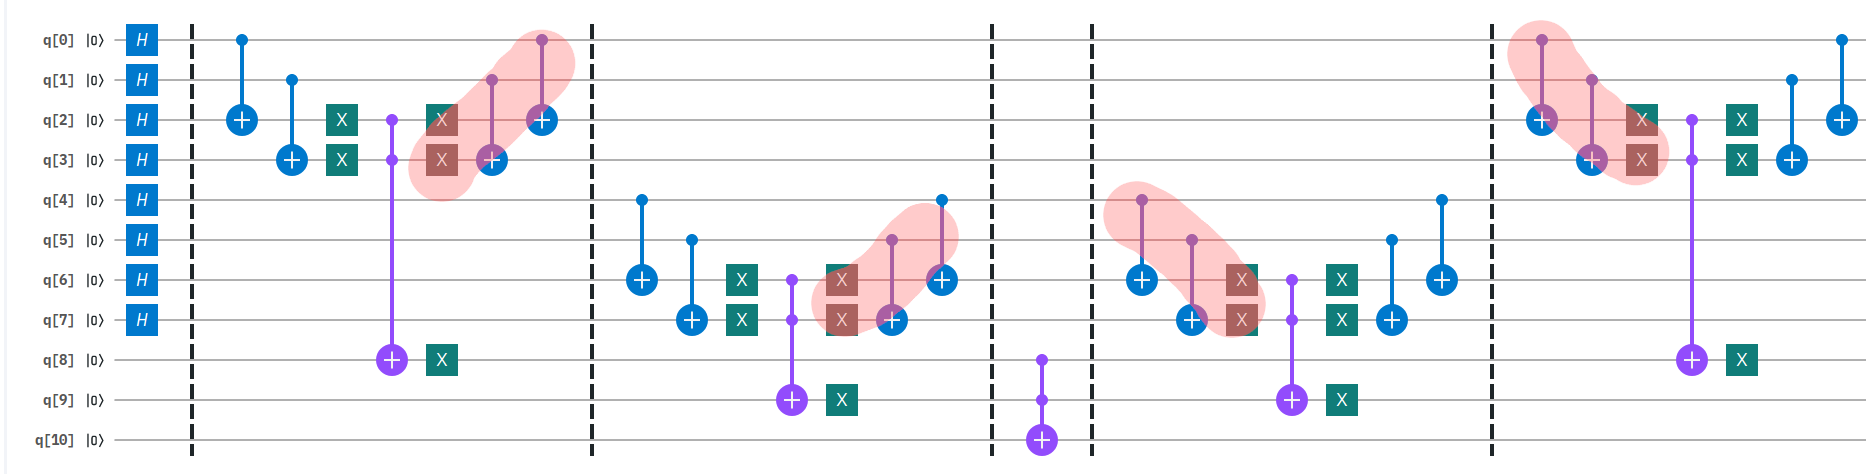

In [5]:
def rccx_opt(qc: QuantumCircuit, a: Qubit, b: Qubit, target: Qubit, side:str="both") -> None:
    if side in ("both", "right"):
        qc.u2(pi / 4, pi, target)       # -H-T-
    qc.cx(b, target)
    qc.tdg(target)
    qc.cx(a, target)
    qc.t(target)
    qc.cx(b, target)
    if side in ("both", "left"):
        qc.u2(0, 3 * pi / 4, target)    # -Tdg-H-

In [6]:
def my_rmct_v_chain(qc: QuantumCircuit, control_qubits: Sequence[Qubit], target_qubit: Qubit, ancillary_qubits: Sequence[Qubit], side: str="both") -> None:
    if len(ancillary_qubits) < len(control_qubits) - 2:
        raise ValueError('Insufficient number of ancillary qubits.')
    
    anci_idx = 0
    rccx_opt(qc, control_qubits[0], control_qubits[1], ancillary_qubits[anci_idx], "left")
    for idx in range(2, len(control_qubits) - 1):
        rccx_opt(qc, control_qubits[idx], ancillary_qubits[anci_idx], ancillary_qubits[anci_idx + 1])
        anci_idx += 1

    rccx_opt(qc, control_qubits[len(control_qubits) - 1], ancillary_qubits[anci_idx], target_qubit, side)

    for idx in reversed(range(2, len(control_qubits) - 1)):
        rccx_opt(qc, control_qubits[idx], ancillary_qubits[anci_idx - 1], ancillary_qubits[anci_idx])
        anci_idx -= 1
    rccx_opt(qc, control_qubits[0], control_qubits[1], ancillary_qubits[anci_idx], "right")

## Constraining Possible Results

Given the building blocks introduced above, the following functions encode the constraints of the problem in a bottom-up fashion. 
First we define functions that ensure a node is different from a fixed *A*, *B*, *C*, or *D* (or *AC* for node 2) as well as a function that ensures two given nodes are assigned different colors/brands.

In [7]:
def aXor(a: Sequence[Qubit], target: Qubit, side: str) -> None:
    rccx_opt(qc, a[0], a[1], target, side)


def bXor(a: Sequence[Qubit], target: Qubit, side: str) -> None:
    if side in ("left"):
        qc.x(a[0])

    rccx_opt(qc, a[0], a[1], target, side)

    if side in ("right"):
        qc.x(a[0])


def cXor(a: Sequence[Qubit], target: Qubit, side: str) -> None:
    if side in ("left"):
        qc.x(a[1])

    rccx_opt(qc, a[0], a[1], target, side)

    if side in ("right"):
        qc.x(a[1])


def dXor(a: Sequence[Qubit], target: Qubit, side: str) -> None:
    rccx_opt(qc, a[0], a[1], target, side)


def acXor(a: Sequence[Qubit], target: Qubit, side: str) -> None:
    if side in ("left"):
        qc.x(a[1])
    qc.cx(a[1], target)
    if side in ("right"):
        qc.x(a[1])

Given qubits representing nodes *a* and *b*, their colors/brands are different if $(a_0 \oplus b_0) \lor (a_1 \oplus b_1)$. 
The circuit representation is shown in the following:

**Figure 2**: 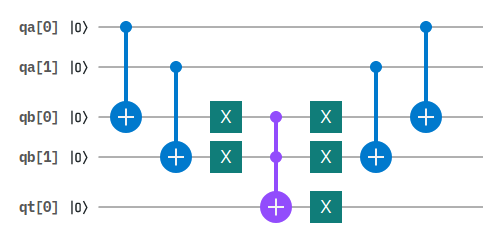

Note this does not require any ancillary qubits and the effects of the computation are *uncomputed* afterwards to restore the previous state.
The function below has an additional parameter `side` to save gates in the same fashion as explained for the building blocks above.

In [8]:
def valueXor_noancilla(a: Sequence[Qubit], b: Sequence[Qubit], target: Qubit, side: str):
    if side == "left":
        qc.cx(a[0], b[0])
        qc.cx(a[1], b[1])

        if b != [q[6], q[7]]:
            qc.x(b[0])
            qc.x(b[1])

        rccx_opt(qc, b[0], b[1], target, side)
    elif side == "right":
        rccx_opt(qc, b[0], b[1], target, side)

        if b != [q[6], q[7]]:
            qc.x(b[1])
            qc.x(b[0])

        qc.cx(a[1], b[1])
        qc.cx(a[0], b[0])
    else:
        raise ValueError("side was neither left nor right")

The functions defined above are now composed to handle the general case, where (at least) one parameter is an actual node and the second parameter possibly is one of the preassigned nodes.

In [9]:
def constrain_nodes(a: Node, b: Node, target: Qubit, side: str) -> None:
    c, d = sorted((a, b))
    if c < 0 or c > 6 or d < 0 or (d > 6 and d not in (A, B, C, D, AC)):
        raise ValueError()
    a_slice = slice(2 * a, 2 * a + 2)
    b_slice = slice(2 * b, 2 * b + 2)
    if d < A:
        valueXor_noancilla(q[a_slice], q[b_slice], q[target], side)
    elif b == A:
        aXor(q[a_slice], q[target], side)
    elif b == B:
        bXor(q[a_slice], q[target], side)
    elif b == C:
        cXor(q[a_slice], q[target], side)
    elif b == D:
        dXor(q[a_slice], q[target], side)
    elif b == AC:
        acXor(q[a_slice], q[target], side)
    else:
        raise ValueError()

Due to the restricted number of qubits in the competition, we constrain two pairs of nodes at once and save the result on another qubit (cf. Figure 1).
For our implementation, we need 8 of these target qubits to save the result.
Furthermore, we use ancillary qubits to store the interim results.

After determining whether the nodes are different, the computation has to be reversed to ensure the inputs are not altered and may be re-used.

In [10]:
def constrain_pair(pair_a: Tuple[Node, Node], pair_b: Tuple[Node, Node], target: Qubit, side="both") -> None:
    if len({pair_a[0], pair_a[1], pair_b[0], pair_b[1]}) != 4:
        raise ValueError('Nodes need to be different.')

    constrain_nodes(pair_a[0], pair_a[1], ANC_1, "left")
    constrain_nodes(pair_b[0], pair_b[1], ANC_2, "left")
    rccx_opt(qc, q[ANC_1], q[ANC_2], q[target], side)
    constrain_nodes(pair_b[0], pair_b[1], ANC_2, "right")
    constrain_nodes(pair_a[0], pair_a[1], ANC_1, "right")

Node 2 is special in the sense that it cannot assume the colors/brands *A* and *C*. This property is exploited to save costs since due to the representation required in the challenge `q[5]` simply has to be *1*.

In [11]:
def constrain_pair_ac(pair_a: Tuple[Node, Node], target: Qubit, side="both") -> None:
    constrain_nodes(pair_a[0], pair_a[1], ANC_1, "left")
    rccx_opt(qc, q[ANC_1], q[5], q[target], side)
    constrain_nodes(pair_a[0], pair_a[1], ANC_1, "right")

Another exploitable property that is obvious by just looking at the graph, is the edge between nodes 0 and 1 can be replaced by introducing two "virtual" edges $(0,D)$ and $(1,C)$.

In [12]:
def constrain_pair_0a_1b(target: Qubit, side="both") -> None:
    qc.cx(q[0], q[1])
    qc.cx(q[2], q[3])
    if side in ("right", "both"):
        qc.x(q[3])
    rccx_opt(qc, q[1], q[3], q[target], side)
    if side in ("left", "both"):
        qc.x(q[3])
    qc.cx(q[2], q[3])
    qc.cx(q[0], q[1])

The `oracle` calls the functions defined above with the appropriate parameters as defined by the graph given in the problem description.

First, node 0 and 1 are constrained as per the property described above -- followed by the constraints for node 2.
The calls to `constrain_pair(...)` correspond to the edges in the graph. 
The last three edges are handled as a triple instead of a pair to reduce the costs. 
Note that it suffices to calculate these intermediate results up to relative phase.

The call to `my_mct_v_chain(...)` negates our final target qubit. Due to the qubit preparation shown below, this results in a phase flip as required by Grover's algorithm.

In [13]:
def oracle() -> None:
    constrain_pair_0a_1b(22, "left")
    qc.barrier()
    constrain_pair_ac((4, B), 23, "left")
    qc.barrier()
    constrain_pair((3, A), (6, D), 24, "left")
    qc.barrier()
    constrain_pair((2, 3), (5, D), 25, "left")
    qc.barrier()
    constrain_pair((6, 3), (0, 2), 26, "left")
    qc.barrier()
    constrain_pair((5, 2), (4, 3), 27, "left")
    qc.barrier()
    constrain_pair((5, 6), (0, 3), 28, "left")
    qc.barrier()
    constrain_pair((4, 6), (1, 3), 29, "left")
    qc.barrier()

    constrain_nodes(5, 3, ANC_1, "left")
    constrain_nodes(2, 6, ANC_2, "left")
    constrain_nodes(4, 1, ANC_3, "left")
    my_rmct_v_chain(qc, [q[ANC_1], q[ANC_2], q[ANC_3]], q[30], q[17:22], "left")

    rccx_opt(qc, q[2], q[3], q[ANC_2], "right")
    rccx_opt(qc, q[12], q[13], q[ANC_3], "right")
    qc.barrier()

    my_mct_v_chain(qc, q[22:31], q[31], q[15:22])

    qc.barrier()
    rccx_opt(qc, q[12], q[13], q[ANC_3], "left")
    rccx_opt(qc, q[2], q[3], q[ANC_2], "left")

    my_rmct_v_chain(qc, [q[ANC_1], q[ANC_2], q[ANC_3]], q[30], q[17:22], "right")
    constrain_nodes(4, 1, ANC_3, "right")
    constrain_nodes(2, 6, ANC_2, "right")
    constrain_nodes(5, 3, ANC_1, "right")

    qc.barrier()
    constrain_pair((4, 6), (1, 3), 29, "right")
    qc.barrier()
    constrain_pair((5, 6), (0, 3), 28, "right")
    qc.barrier()
    constrain_pair((5, 2), (4, 3), 27, "right")
    qc.barrier()
    constrain_pair((6, 3), (0, 2), 26, "right")
    qc.barrier()
    constrain_pair((2, 3), (5, D), 25, "right")
    qc.barrier()
    constrain_pair((3, A), (6, D), 24, "right")
    qc.barrier()
    constrain_pair_ac((4, B), 23, "right")
    qc.barrier()
    constrain_pair_0a_1b(22, "right")
    qc.barrier()

The diffusion is the default Grover diffusion with single qubit gates fused where appropriate.

In [14]:
def diffusion() -> None:
    qc.u2(0, 0, q[0:3])                 # -H-X-
    qc.u3(3 * pi / 2, 0, pi, q[3])      # -X-H-X
    qc.u2(0, 0, q[4:6])                 # -H-X-
    qc.u3(3 * pi / 2, 0, pi, q[6:8])    # -X-H-X
    qc.u2(0, 0, q[8:13])                # -H-X-
    qc.u2(0, 0, q[13])                  # -Z-H-

    anci_idx = 0
    rccx_opt(qc, q[0], q[1], q[18+anci_idx], "left")
    for idx in range(2, 12):
        rccx_opt(qc, q[idx], q[18+anci_idx], q[18+anci_idx+1], "left")
        anci_idx += 1

    qc.cx(q[18+anci_idx], q[13])
    qc.tdg(q[13])
    qc.cx(q[12], q[13])
    qc.t(q[13])
    qc.cx(q[18+anci_idx], q[13])
    qc.tdg(q[13])
    qc.cx(q[12], q[13])
    qc.t(q[18+anci_idx])
    qc.cx(q[12], q[18+anci_idx])
    qc.t(q[12])
    qc.tdg(q[18+anci_idx])
    qc.cx(q[12], q[18+anci_idx])

    for idx in reversed(range(2, 12)):
        rccx_opt(qc, q[idx], q[18+anci_idx - 1], q[18+anci_idx], "right")
        anci_idx -= 1
    rccx_opt(qc, q[0], q[1], q[18+anci_idx], "right")

    qc.u2(pi, 5*pi/4, q[13])            # -T-H-Z-
    qc.u2(pi, pi, q[8:13])              # -X-H-
    qc.u3(3 * pi / 2, 0, pi, q[6:8])    # -X-H-X-
    qc.u2(pi, pi, q[4:6])               # -X-H-
    qc.u3(3 * pi / 2, 0, pi, q[3])      # -X-H-X-
    qc.u2(pi, pi, q[0:3])               # -X-H-

The challenge required to use Grover's algorithm with 5 iterations.
In the code below we prepare the qubits for the algorithm and fuse consecutive single qubit gates.

In [15]:
q = QuantumRegister(32, 'q')
c = ClassicalRegister(14, 'c')
qc = QuantumCircuit(q, c)
ANC_1 = 14
ANC_2 = 15
ANC_3 = 16

# preparation
qc.h(q[0:3])  # -H-
qc.u2(0, 0, q[3])  # -H-X- implicitly negate q[3]
qc.h(q[4:6])  # -H-
qc.u2(0, 0, q[6:8])  # -H-X- implicitly negate the '3' qubits
qc.h(q[8:14])  # -H-
qc.u2(5 * pi / 4, pi, q[14:17])  # -X-H-T- prepare "tree" ancilla
qc.u2(pi / 4, pi, q[17:31])  # -H-T- prepare "mct" ancilla
qc.x(q[31])  # -X- prepare target

for _ in range(5):
    oracle()
    diffusion()

qc.x(q[6:8])  # reverse the negation of the '3' qubits
qc.x(q[3])  # reverse the negation of q[3]

# final measurement
qc.measure(q[0:14], c[0:14])

## Costs of our Approach

While we omitted the code to submit the circuit to IBM Q, calculating the cost is fast and, thus, included in this write-up.

In [16]:
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
unrolled_circuit = pm.run(qc)
uc_gates = unrolled_circuit.count_ops()
print('gates: {}'.format(dict(uc_gates)))
print('costs: {}'.format(uc_gates['cx'] * 10 + uc_gates['u3']))

gates: {'cx': 2320, 'u3': 2290, 'barrier': 95, 'measure': 14}
costs: 25490
